In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg as la
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
%precision 4
#ATTENTION: Dealing with some linear depedent variable sometimes the svd algorithm does not converge,
#I do not know if this is due to the version of numpy (1.19 gives sometimes some problems)
#Anyway in those cases it is sufficient to rerun the cell without changing anything

'%.4f'

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [2]:
N = 2000
x1 = np.random.normal(size = (N,1))
x2 = x1 + np.random.normal(scale = 3., size = (N,1))
x3 = 2*x1 + x2

X = np.concatenate((x1, x2, x3), axis = 1)
Sigma = np.cov(X.T)
avl, avt = la.eig(Sigma)
print("eigenvalues: ", np.real_if_close(avl))
print("eigenvectors:\n", avt)

"""As we expected there is an eigenvalue that is almost zero (<10**(-15)). Remember that x_3 is a linear combination of the other two variables"""

eigenvalues:  [2.7719e+01 2.7636e-16 1.9276e+00]
eigenvectors:
 [[-0.1158 -0.8165  0.5656]
 [-0.577  -0.4082 -0.7074]
 [-0.8085  0.4082  0.4239]]


'As we expected there is an eigenvalue that is almost zero (<10**(-15)). Remember that x_3 is a linear combination of the other two variables'

In [3]:
U, D_diag, V = la.svd(X.T)
avl_svd = D_diag**2/(N-1)
avt_svd = U
print("eigenvalues from SVD: ", np.real_if_close(avl_svd))
print("eigenvectors from SVD:\n", avt_svd)

"""The two biggest eigenvalues calculated in the two methods are very similar. The third one is almost zero in both cases, the difference is probabliy due to the precision of the algorithms. Note the corrispondence of the eigenvectors"""

eigenvalues from SVD:  [2.7726e+01 1.9276e+00 2.4172e-30]
eigenvectors from SVD:
 [[-0.1158  0.5656 -0.8165]
 [-0.577  -0.7074 -0.4082]
 [-0.8085  0.4239  0.4082]]


'The two biggest eigenvalues calculated in the two methods are very similar. The third one is almost zero in both cases, the difference is probabliy due to the precision of the algorithms. Note the corrispondence of the eigenvectors'

The first two principal components express the 100.00 % of the dataset variability


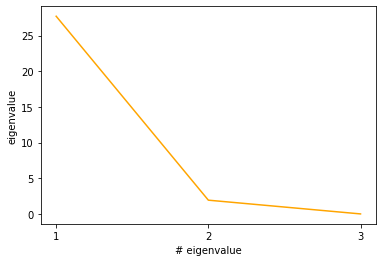

'Looking at the rotation matrix we can analyze how the pricipal components can be computed from the initial data. For each principal component (column) and each feature (row), the biggest is an element of the rotation matrix, the strongest is the contribution of the feature to that principal component'

In [4]:
m = np.argsort(avl)[::-1]
avl_ordered = avl[m]
avt_T = avt.T
avt_T_ordered = avt_T[m]
vv = (avl_ordered[0]+avl_ordered[1])/avl.sum()
print("The first two principal components express the %.2f %% of the dataset variability" %(np.real_if_close(vv)*100))
fig, ax = plt.subplots()
ax.plot(np.arange(3)+1, np.real_if_close(avl_ordered), color = 'orange')
ax.set_xlabel('# eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

"""Looking at the rotation matrix we can analyze how the pricipal components can be computed from the initial data. For each principal component (column) and each feature (row), the biggest is an element of the rotation matrix, the strongest is the contribution of the feature to that principal component"""

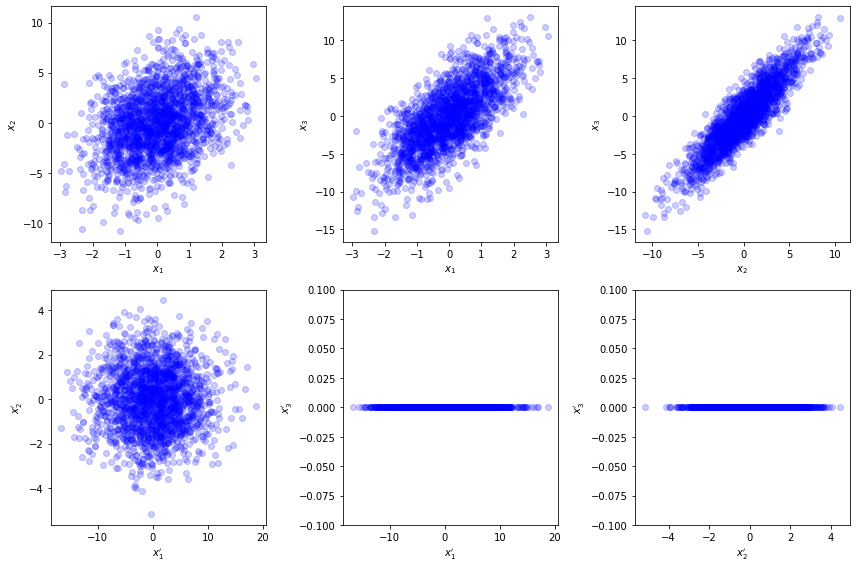

'In the last two plots the y_range was chosen appositely to show the fact that the rotated datasets has neglegible variance along the third axis'

In [5]:
XT = np.dot(avt_T_ordered, X.T).T
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
#Rotation of dataset with PCA eigenvectors

ax1.plot(X[:,0], X[:,1], 'bo', alpha = 0.2)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax2.plot(X[:,0], X[:,2], 'bo', alpha = 0.2)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_3$')
ax3.plot(X[:,1], X[:,2], 'bo', alpha = 0.2)
ax3.set_xlabel('$x_2$')
ax3.set_ylabel('$x_3$')
ax4.plot(XT[:,0], XT[:,1], 'bo', alpha = 0.2)
ax4.set_xlabel("$x_1'$")
ax4.set_ylabel("$x_2'$")
ax5.plot(XT[:,0], XT[:,2], 'bo', alpha = 0.2)
ax5.set_xlabel("$x_1'$")
ax5.set_ylabel("$x_3'$")
ax5.set_ylim(-0.1, 0.1)
ax6.plot(XT[:,1], XT[:,2], 'bo', alpha = 0.2)
ax6.set_xlabel("$x_2'$")
ax6.set_ylabel("$x_3'$")
ax6.set_ylim(-0.1, 0.1)
plt.tight_layout()
plt.show()

"""In the last two plots the y_range was chosen appositely to show the fact that the rotated datasets has neglegible variance along the third axis"""

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

[2.7726e+01 1.9276e+00 4.4770e-04 4.3704e-04 4.2220e-04 4.1118e-04
 4.0765e-04 3.9814e-04 3.9240e-04 3.8386e-04 3.6644e-04 3.5276e-04
 4.8031e-31]
The first two principal components express the 99.99 % of the dataset variability


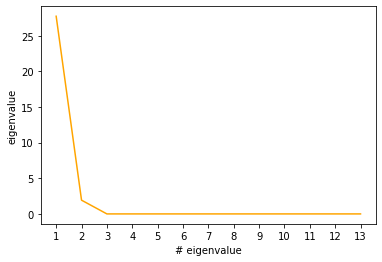

[[-0.116  0.566]
 [-0.577 -0.707]
 [-0.809  0.424]
 [-0.    -0.   ]
 [ 0.    -0.   ]
 [ 0.    -0.   ]
 [-0.    -0.   ]
 [-0.     0.   ]
 [-0.     0.001]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [-0.    -0.   ]
 [ 0.     0.   ]]


'Also in this case most part of the variability of the dataset is expressed by the first two principal components. Looking at the eigenvalues it is possible to see that the two biggest one eigenvalues are the same of the previous case. This is what we expected as we only introduced some incorrelated noise with a minor variance. Also the rotation matrix (here the first two vectors are printed) have the components related to the initial x_1, x_2, x_3 that are the same. That means that the first two principal components are the same as before. The noise is totally uncorrelated so does not affect the first two eigenvectors'

In [7]:
std = 1/50
X_noise = np.random.normal(scale = std, size=(N, 10))
X_new = np.concatenate((X, X_noise), axis = 1)
U, D_diag, V = la.svd(X_new.T)
avl_svd = D_diag**2/(N-1)
print(avl_svd)
vv = (avl_svd[0]+avl_svd[1])/avl_svd.sum()
print("The first two principal components express the %.2f %% of the dataset variability" %(np.real_if_close(vv)*100))
fig, ax = plt.subplots()
ax.plot(np.arange(13)+1, np.real_if_close(avl_svd), color = 'orange')
ax.set_xlabel('# eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(U[:,:2])

"""Also in this case most part of the variability of the dataset is expressed by the first two principal components. Looking at the eigenvalues it is possible to see that the two biggest one eigenvalues are the same of the previous case. This is what we expected as we only introduced some incorrelated noise with a minor variance. Also the rotation matrix (here the first two vectors are printed) have the components related to the initial x_1, x_2, x_3 that are the same. That means that the first two principal components are the same as before. The noise is totally uncorrelated so does not affect the first two eigenvectors"""

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


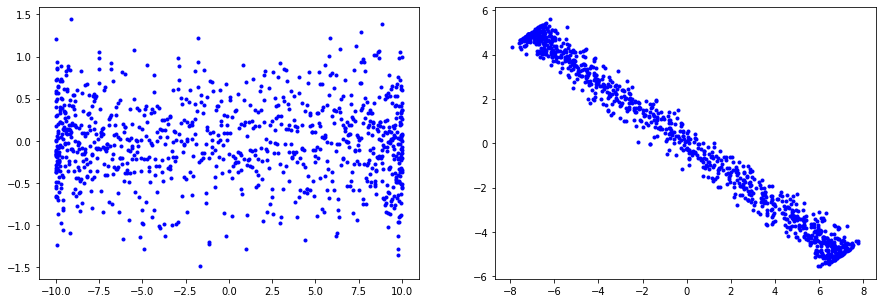

'After creating the dataset, we used a rotation matrix to emulate the vision of a camera defined by (theta, phi) in spherical coordinates. Each camera is described by a rotation matrix R'

In [8]:
N = 1000
phi = 0
omega = 0.2
A = 10
t = np.arange(N)
def string(t, A, omega, phi):                       #Create the string motion
    return(A*np.cos(omega*t + phi))
x = string(t, A, omega, phi)[:,np.newaxis]
#plt.plot(t, x)
y = np.random.normal(scale = 0.5, size = (N, 1))
z = np.zeros((N, 1))
X = np.concatenate((x, y, z), axis = 1)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(X[:,0], X[:,1], 'b.')

def rotation(X, Theta, Phi):
    Theta = Theta*np.pi/180
    Phi = Phi*np.pi/180
    Rtheta = np.array([[1, 0, 0],
                      [0, np.cos(Theta), np.sin(Theta)],
                      [0, -np.sin(Theta), np.cos(Theta)]])
    Rphi = np.array([[np.cos(Phi), np.sin(Phi), 0],
                    [-np.sin(Phi), np.cos(Phi), 0],
                    [0, 0, 1]])
    R = np.dot(Rtheta, Rphi)                           #Rotation matrix
    return np.dot(R, X.T).T, R

Xr, R = rotation(X, 45, 45)
ax2.plot(Xr[:,0], Xr[:,1], 'b.')
plt.show()

"""After creating the dataset, we used a rotation matrix to emulate the vision of a camera defined by (theta, phi) in spherical coordinates. Each camera is described by a rotation matrix R"""

[49.983  0.236  0.   ]
The first principal component express the 99.53 % of the dataset variability


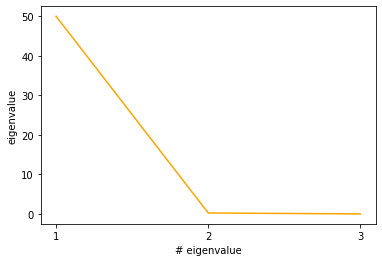

In [9]:
U, D_diag, V = la.svd(Xr.T)
avl_svd = D_diag**2/(N-1)
print(avl_svd)
vv = avl_svd[0]/avl_svd.sum()
print("The first principal component express the %.2f %% of the dataset variability" %(np.real_if_close(vv)*100))
fig, ax = plt.subplots()
ax.plot(np.arange(3)+1, np.real_if_close(avl_svd), color = 'orange')
ax.set_xlabel('# eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

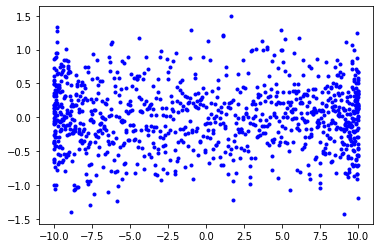

[[-0.706  0.501 -0.501]
 [-0.708 -0.499  0.499]
 [-0.     0.707  0.707]]
[[ 0.707 -0.5    0.5  ]
 [ 0.707  0.5   -0.5  ]
 [ 0.     0.707  0.707]]


'As can be seen in the figure the rotating the i-th camera dataset with the eigenvalues matrix we obtain the original figure with no rotations (or a reflected one). That means that the principal components of the figure are the original cardinal axes. Notice that the matrix U is the same as matrix R^(-1) except from some sign that causes some axis to be reflected. This means that rotating the i-th camera dataset with PCA we obtain the original created dataset'

In [11]:
Xrr = np.dot(U.T, Xr.T).T #Applying PCA rotation
plt.plot(Xrr[:,0], Xrr[:,1], 'b.')
plt.show()
print(U.T)
print(R.T)

"""As can be seen in the figure the rotating the i-th camera dataset with the eigenvalues matrix we obtain the original figure with no rotations (or a reflected one). That means that the principal components of the figure are the original cardinal axes. Notice that the matrix U is the same as matrix R^(-1) except from some sign that causes some axis to be reflected. This means that rotating the i-th camera dataset with PCA we obtain the original created dataset"""

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [12]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

In [13]:
labels = ['fLength','fWidth','fSize','fConc','fConc1','fAsym', 'fM3Long','fM3Trans','fAlpha','fDist','category']
Data = pd.read_csv('data/magic04.data', names = labels)
Data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,category
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [14]:
X = Data.values[:,:-1]
N = X.shape[0]
X = X.astype('float64')
H = np.eye(N)-1/N*np.ones((N,1)).dot(np.ones((1,N)))    #Centering matrix
S = np.cov(X.T)
XS = np.dot(H, X) #Centred data
np.set_printoptions(precision=0)
np.set_printoptions(suppress=True)
print(np.cov(XS.T))

"""We are going to apply the PCA on Centred Data (mean = [0, 0...,0])"""

[[1795.  599.   14.   -5.   -3. -924. -259.   12.  -10. 1325.]
 [ 599.  337.    6.   -2.   -1. -290. -165.   15.   32.  462.]
 [  14.    6.    0.   -0.   -0.   -4.    2.    0.   -2.   15.]
 [  -5.   -2.   -0.    0.    0.    1.   -1.   -0.    1.   -4.]
 [  -3.   -1.   -0.    0.    0.    1.   -1.   -0.    1.   -3.]
 [-924. -290.   -4.    1.    1. 3505.  827.    3.  -86. -915.]
 [-259. -165.    2.   -1.   -1.  827. 2601.  -18. -248.  141.]
 [  12.   15.    0.   -0.   -0.    3.  -18.  434.    3.   18.]
 [ -10.   32.   -2.    1.    1.  -86. -248.    3.  681. -430.]
 [1325.  462.   15.   -4.   -3. -915.  141.   18. -430. 5585.]]


'We are going to apply the PCA on Centred Data (mean = [0, 0...,0])'

[47740.94   4198.561  2084.526  1338.613   821.44    433.667   117.362
     0.564     0.035     0.   ]


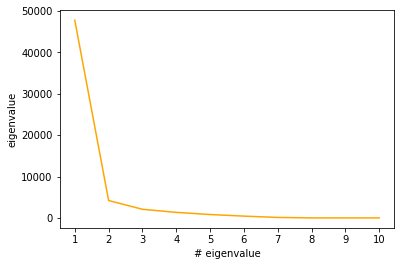

[0.841 0.915 0.952 0.976 0.99  0.998 1.    1.    1.    1.   ]


"As can be seen from the vector 'cumsum' the first 2 principal components express the 91% of variability, the first 3 principal components express the 95% of variability"

In [15]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
U, D_diag, V = la.svd(X.T)
avl_svd = D_diag**2/(N-1)
print(avl_svd)
fig, ax = plt.subplots()
ax.plot(np.arange(len(avl_svd))+1, np.real_if_close(avl_svd), color = 'orange')
ax.set_xlabel('# eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

fr = avl_svd/avl_svd.sum() 
print(fr.cumsum()) #Cumulant of variability expressed
"""As can be seen from the vector 'cumsum' the first 2 principal components express the 91% of variability, the first 3 principal components express the 95% of variability"""

In [16]:
print(U[:,:3])
"""From the rotation matrix we can see that the 1st principal component reflects principally the 'fDist' feature, the second reflects more the 'fAsym' variable, the third is bounded to the 'fM3Long' variable"""

[[-0.266 -0.237 -0.065]
 [-0.108 -0.083  0.025]
 [-0.012  0.002  0.001]
 [-0.002  0.001  0.001]
 [-0.001  0.     0.001]
 [ 0.045  0.815  0.511]
 [-0.047  0.512 -0.841]
 [-0.002 -0.002  0.011]
 [-0.111 -0.032  0.15 ]
 [-0.949  0.093  0.064]]


"From the rotation matrix we can see that the 1st principal component reflects principally the 'fDist' feature, the second reflects more the 'fAsym' variable, the third is bounded to the 'fM3Long' variable"

In [17]:
D = np.diag(np.diag(S)**(-0.5))
XS = np.dot(H, np.dot(X, D))
print(np.cov(XS.T))

"""We are going to repeat the PCA analysis on Standardized Data (mean = [0, 0...,0], Cov = Corr) in order to avoid big eigenvalues due to different scales of measure. 
Note that the covarince matrix is a correlaton matrix. This means that data are standardized""" 

[[ 1.     0.771  0.702 -0.631 -0.598 -0.369 -0.12   0.013 -0.009  0.418]
 [ 0.771  1.     0.718 -0.61  -0.581 -0.267 -0.176  0.04   0.066  0.337]
 [ 0.702  0.718  1.    -0.851 -0.809 -0.16   0.095  0.015 -0.187  0.437]
 [-0.631 -0.61  -0.851  1.     0.976  0.112 -0.122 -0.011  0.235 -0.328]
 [-0.598 -0.581 -0.809  0.976  1.     0.1   -0.119 -0.011  0.23  -0.305]
 [-0.369 -0.267 -0.16   0.112  0.1    1.     0.274  0.003 -0.056 -0.207]
 [-0.12  -0.176  0.095 -0.122 -0.119  0.274  1.    -0.017 -0.186  0.037]
 [ 0.013  0.04   0.015 -0.011 -0.011  0.003 -0.017  1.     0.005  0.011]
 [-0.009  0.066 -0.187  0.235  0.23  -0.056 -0.186  0.005  1.    -0.221]
 [ 0.418  0.337  0.437 -0.328 -0.305 -0.207  0.037  0.011 -0.221  1.   ]]


'We are going to repeat the PCA analysis on Standardized Data (mean = [0, 0...,0], Cov = Corr) in order to avoid big eigenvalues due to different scales of measure. \nNote that the covarince matrix is a correlaton matrix. This means that data are standardized'

[4.224 1.575 1.012 0.994 0.742 0.65  0.408 0.22  0.155 0.02 ]


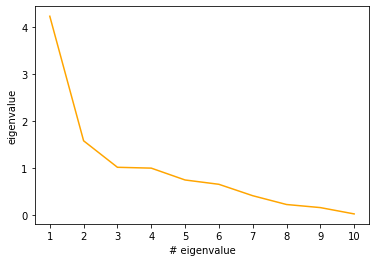

[0.422 0.58  0.681 0.78  0.855 0.92  0.96  0.983 0.998 1.   ]


"As can be seen from the vector 'cumsum' the first 5 principal componets of the standardized data express the 85% of variability"

In [19]:
U, D_diag, V = la.svd(XS.T)
avl_svd = D_diag**2/(N-1)
print(avl_svd)
fig, ax = plt.subplots()
ax.plot(np.arange(len(avl_svd))+1, np.real_if_close(avl_svd), color = 'orange')
ax.set_xlabel('# eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MultipleLocator(1.000))
plt.show()

fr = avl_svd/avl_svd.sum() 
print(fr.cumsum()) #Cumulant of variability expressed

"""As can be seen from the vector 'cumsum' the first 5 principal componets of the standardized data express the 85% of variability"""

In [20]:
print(U[:,:5])
"""From the rotation matrix (first 5 vector) it is not easy to see a clear dependence of pricipal components from a specific data feature. Every principal component reflects a combination of at least 3-4 features
   (i.e. the first pricipal component reflects a combination among the first 5 features (which roatation elemts are bigger that the other and are similar among them)). The standardization changed the computation of Principal Components avoiding to give more weight to the features with the biggest variance"""

[[-0.408  0.226 -0.001 -0.025  0.119]
 [-0.395  0.245 -0.153 -0.095  0.058]
 [-0.449 -0.093 -0.071 -0.057  0.016]
 [ 0.442  0.188  0.129  0.109  0.181]
 [ 0.429  0.196  0.139  0.116  0.206]
 [ 0.145 -0.487 -0.377 -0.214 -0.023]
 [-0.005 -0.6   -0.058 -0.054  0.599]
 [-0.012  0.031 -0.603  0.795  0.008]
 [ 0.097  0.457 -0.47  -0.386  0.526]
 [-0.257 -0.012  0.454  0.364  0.521]]


'From the rotation matrix (first 5 vector) it is not easy to see a clear dependence of pricipal components from a specific data feature. Every principal component reflects a combination of at least 3-4 features\n   (i.e. the first pricipal component reflects a combination among the first 5 features (which roatation elemts are bigger that the other and are similar among them)). The standardization changed the computation of Principal Components avoiding to give more weight to the features with the biggest variance'